# Imports

In [1]:
from imports.default_imports import *
from imports.functions import * 
from imports.ML_imports import *

import os

wtf
Welcome to JupyROOT 6.22/06


# Part 1 -- Data Preparation

### Create a list of files to process

In [2]:
file_list = []
path = '/../eos/atlas/atlascerngroupdisk/data-dqm/references/'

for idF,file in enumerate(os.listdir(path)):
    if 'data18' in file and 'physics_Main' in file:
        file_list.append(path+file)
        
display(file_list[0])

### Convert hist to dataframe

In [8]:
df_main = hist_to_df(file_list[0])
df_main.head()

,paths,x,y,occ
0,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,0,NaN,0.000000
1,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,1,NaN,73.007064
2,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,2,NaN,165.089993
3,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,3,NaN,162.029158
4,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,4,NaN,128.432800


### Prepare the training dataframe by adding histograms to it that were creating in the previous step

In [9]:
df_train = select_add_hist(df_main,6)
df_train.head()

,paths,x,y,occ
424,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,0,NaN,0.0
425,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,1,NaN,80609664.0
426,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,2,NaN,89605600.0
427,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,3,NaN,89967696.0
428,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,4,NaN,90034216.0


# Part 2 -- Machine Learning (unsupervised)

### Prepare the machine learning models

NOTE: axes on model plots ARE NOT scaled the same way as the plots show up on TBrowser()

### Train and Plot ML algorithms over df_train data

In [27]:
# SET EVERYTHING UP

#for convenience
df = df_train

#setup the data for training depending on if we are using TH1s or TH2s for data
is_th1 = True
if(is_th1):
    Z_eta = df[['x','occ']]
else:
    Z_eta, Z_phi = df[['x','occ']], df[['y','occ']]

    
classifiers = {
        #'ABOD': ABOD(contamination=outliers_fraction),
        #'CBLOF':CBLOF(contamination=outliers_fraction,check_estimator=True, random_state=np.random.RandomState(42)),
        'AE': AutoEncoder(hidden_neurons =[3,2,1,2,3], contamination = 0.06, epochs=500,verbose=0),
        'LOF': LOF(n_neighbors=35, contamination=0.054),
#         'FBag':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction_eta_lof,check_estimator=False,random_state=np.random.RandomState(42)),
        'HBOS': HBOS(contamination=0.08),
        'IF': IForest(contamination=0.03,random_state=np.random.RandomState(42)),
        'KNN': KNN(contamination=0.04),
        'AvgKNN': KNN(method='mean',contamination=0.02)
}

classifiers2 = {
        #'ABOD': ABOD(contamination=outliers_fraction),
        #'CBLOF':CBLOF(contamination=outliers_fraction,check_estimator=True, random_state=random_state),
        'AE': AutoEncoder(hidden_neurons =[3,2,1,2,3], contamination = 0.06, epochs=500,verbose=0),
        'LOF': LOF(n_neighbors=35, contamination=0.008),
#         'FBag':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction_phi_lof,check_estimator=False,random_state=np.random.RandomState(42)),
        'HBOS': HBOS(contamination=0.008),
        'IF': IForest(contamination=0.004,random_state=np.random.RandomState(42)),
        'KNN': KNN(contamination=0.005),
        'AvgKNN': KNN(method='mean',contamination=0.0025)
}


#make sure we only have the three columns in case we re run this
# df = df[['eta','phi','Events']]
# df

W0412 01:34:33.146481 140195770111808 def_function.py:107] 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f80d5365af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
<ipython-input-28-189c8caefeda>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

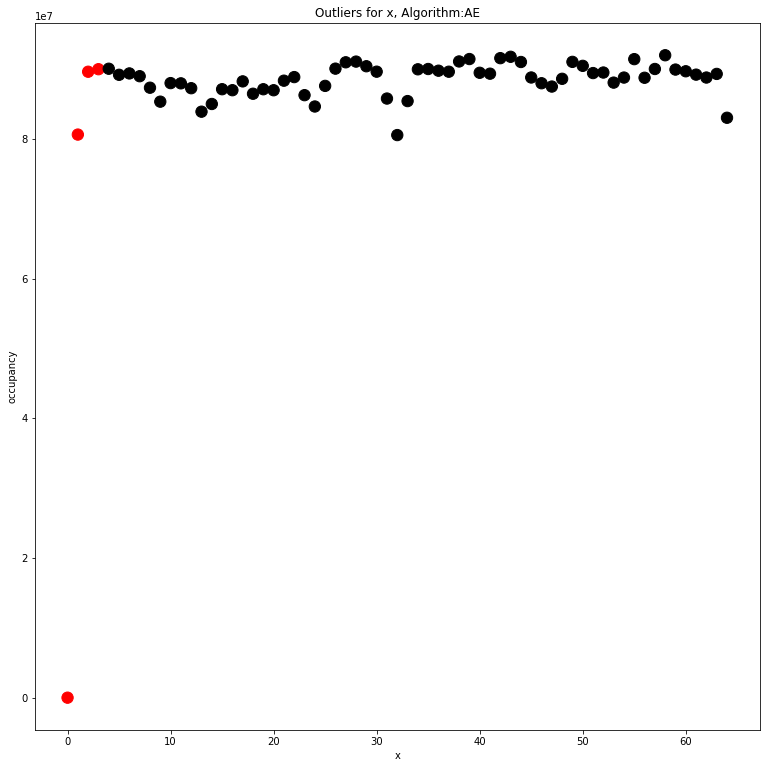

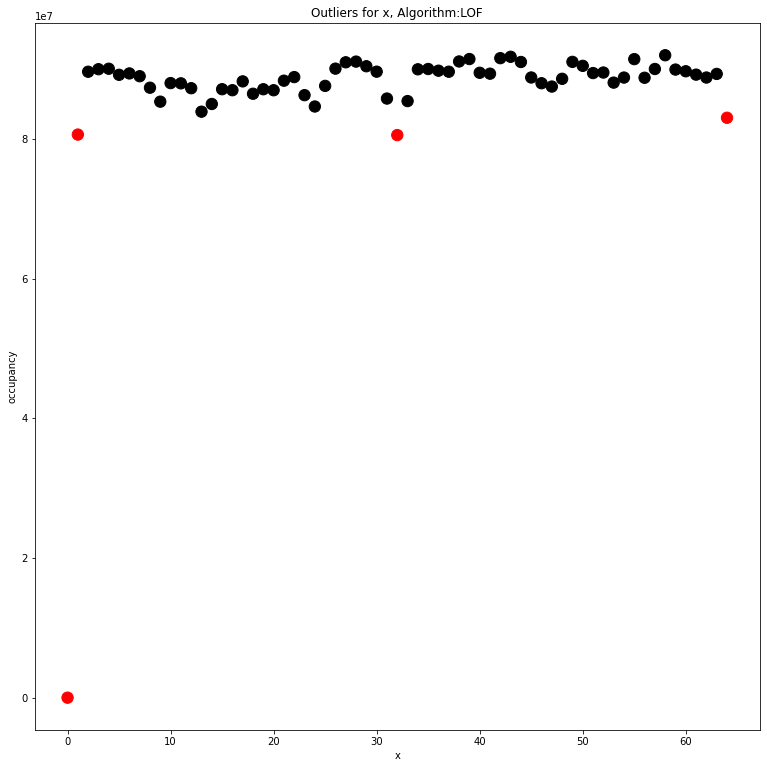

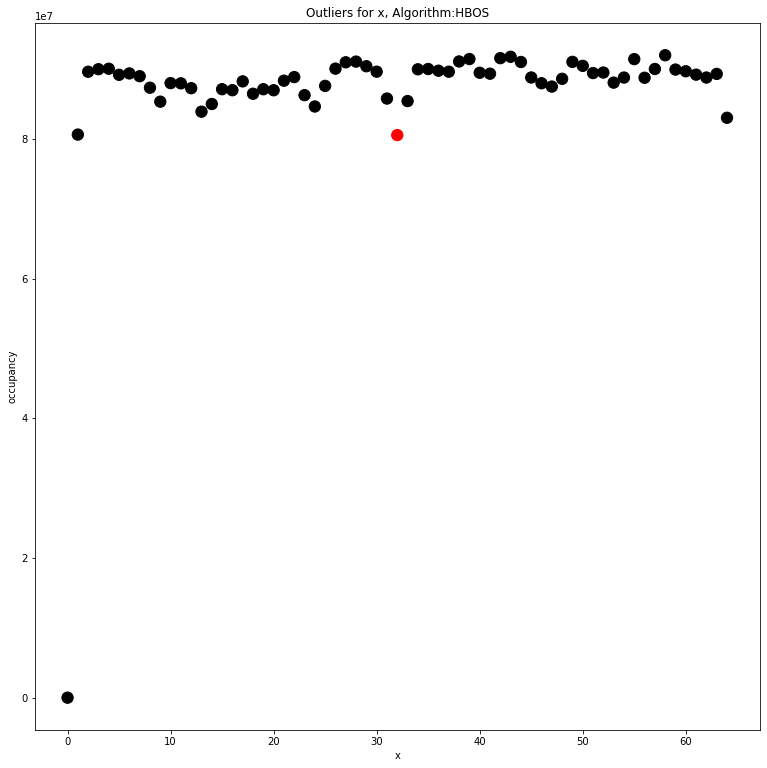

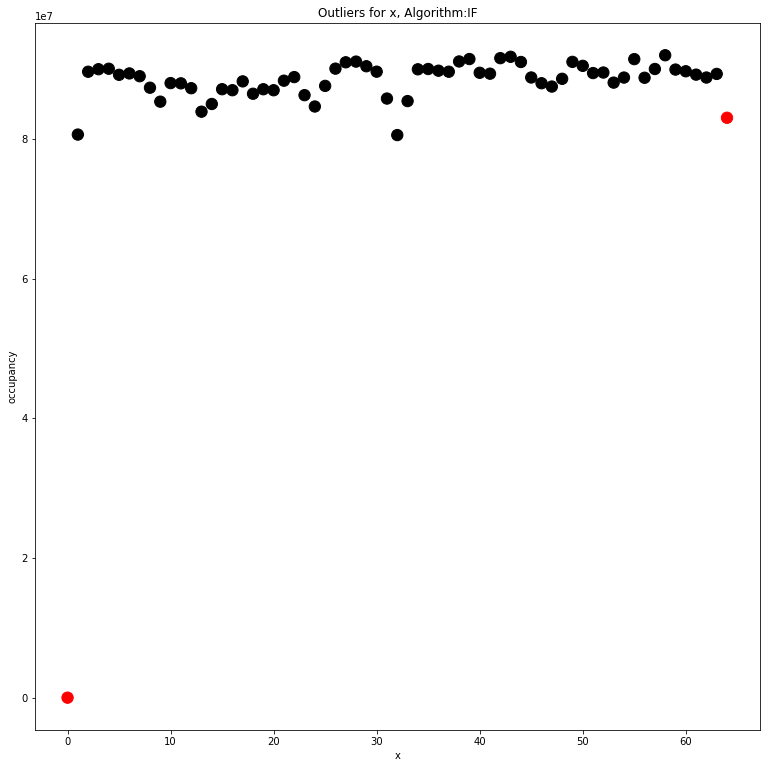

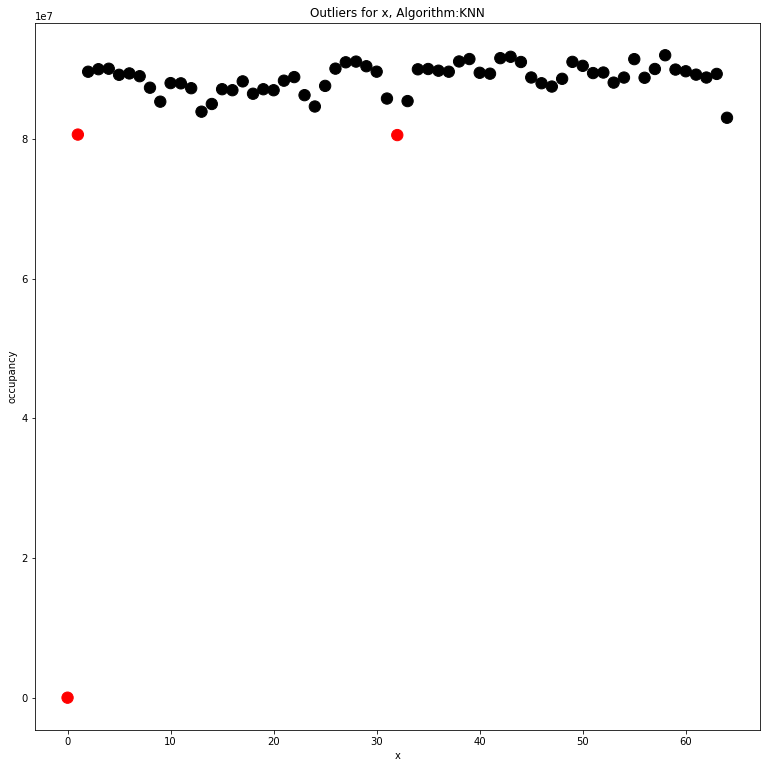

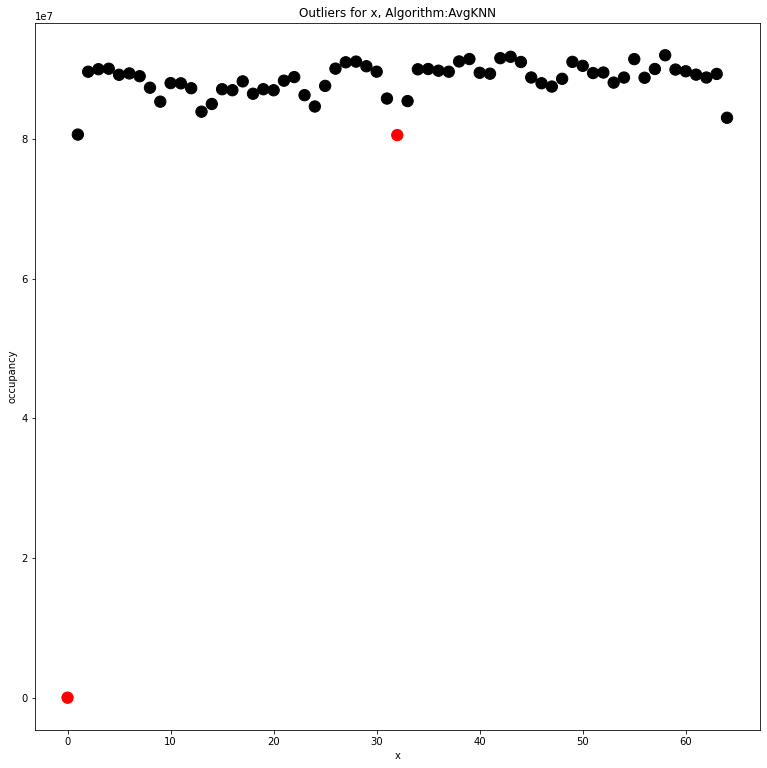

In [28]:
#RUN THE ML ALGORITHMS

#before re-running, clean the dataframe with this line of code below
df = df_train

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(Z_eta)
    tmp = "ol_x_" + clf_name
    df[tmp]   = clf.labels_
    tmp2 = "sc_x_" + clf_name
    df[tmp2] = clf.decision_scores_
    color = np.where(df[tmp] == 1, 'red', 'black')
    
    plt.figure(figsize=(13,13))
    plt.xlabel('x')
    plt.ylabel('occupancy')
    plt.title('Outliers for x, Algorithm:'+clf_name)
    plt.scatter(df['x'],df['occ'], s=128, color=color)

In [ ]:
0.335919 #for sc_x_IF , this score stays the same regardless how you tune the outliers_fraction, this suggests that it could be possible to algorithmically tune this!!!

In [35]:
df

,paths,x,y,occ,ol_x_AE,sc_x_AE,ol_x_LOF,sc_x_LOF,ol_x_HBOS,sc_x_HBOS,ol_x_IF,sc_x_IF,ol_x_KNN,sc_x_KNN,ol_x_AvgKNN,sc_x_AvgKNN
424,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,0,NaN,0.0,1,8.362805,1,39.664504,0,6.419483,1,0.335919,1,8.462822e+07,1,8.253560e+07
425,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,1,NaN,80609664.0,1,2.147156,1,3.296086,0,6.419483,0,0.152712,1,4.378592e+06,0,2.830408e+06
426,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,2,NaN,89605600.0,1,1.903994,0,0.973622,0,6.419482,0,0.001079,0,1.476320e+05,0,6.780966e+04
427,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,3,NaN,89967696.0,1,1.849632,0,0.999688,0,6.419482,0,-0.020684,0,6.652000e+04,0,3.860643e+04
428,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,4,NaN,90034216.0,0,1.796204,0,0.999941,0,6.419482,0,-0.028586,0,8.140001e+04,0,4.720481e+04
429,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,5,NaN,89166512.0,0,1.746482,0,0.937585,0,6.419482,0,-0.039750,0,2.008960e+05,0,1.413984e+05
430,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,6,NaN,89362584.0,0,1.692166,0,0.940410,0,6.419482,0,-0.037580,0,1.292160e+05,0,7.599841e+04
431,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,7,NaN,88965616.0,0,1.641548,0,0.944433,0,6.449477,0,-0.038079,0,2.008960e+05,0,1.795008e+05
432,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,8,NaN,87318464.0,0,1.607921,0,1.163615,0,6.449477,0,-0.044252,0,2.620240e+05,0,1.862128e+05
433,run_349111/CaloMonitoring/ClusterMon/CaloCalTo...,9,NaN,85320064.0,0,1.598039,0,1.672464,0,6.449477,0,0.003778,0,9.317360e+05,0,4.972336e+05


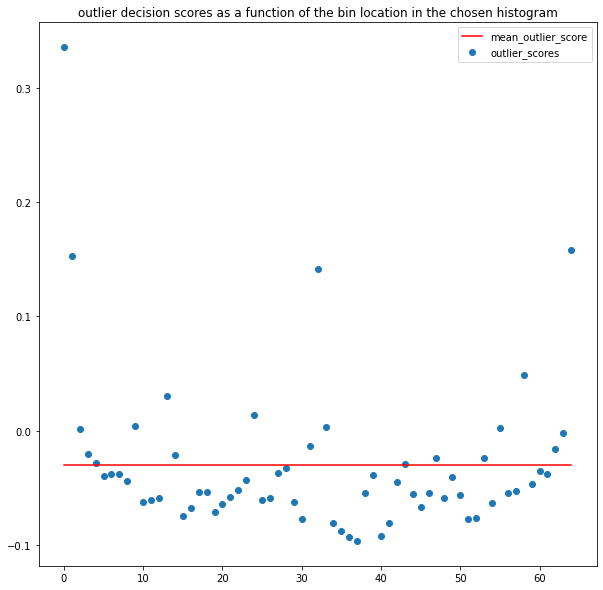

In [115]:
plt.figure(figsize=(10,10))
plt.plot( np.arange(0,len(df['sc_x_IF'].values)) , np.ones(len(df['sc_x_IF'].values))*df['sc_x_IF'].values.mean() ,color='r',label='mean_outlier_score')
plt.title('outlier decision scores as a function of the bin location in the chosen histogram')
plt.scatter( np.arange(0,len(df['sc_x_IF'].values)) , df['sc_x_IF'].values ,label='outlier_scores')
plt.legend()

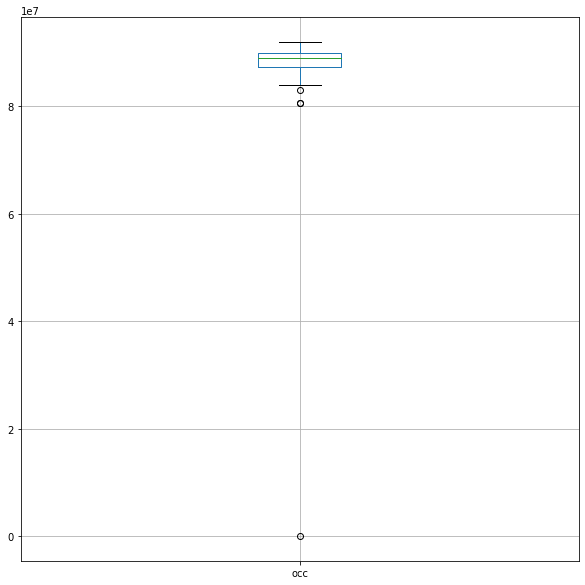

In [116]:
plt.figure(figsize=(10,10))
_, bp = pd.DataFrame.boxplot(df[['occ']], return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

In [119]:
print(f'number of outliers: {len(outliers[0])}')
print(f'occupancy values of outliers: {(outliers[0])}')

number of outliers: 4
occupancy values of outliers: [       0. 80609664. 80537776. 83016328.]


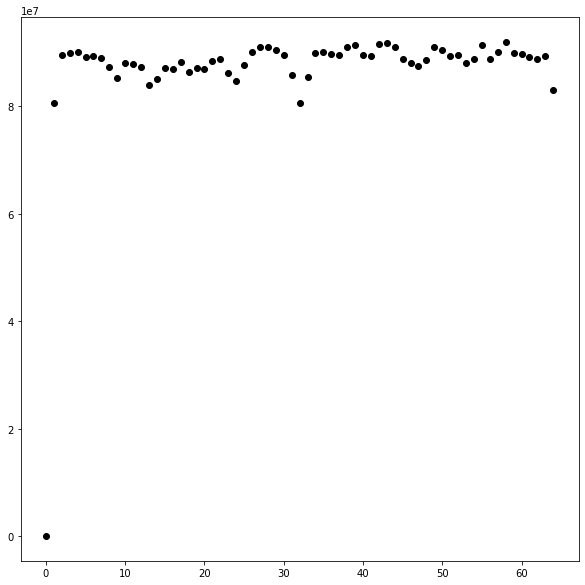

In [123]:
plt.figure(figsize=(10,10))
plt.scatter(df['x'],df['occ'],color='black')

<b>The above correctly identifies what the eye might detect as outliers</b>

SO, I have shown that in order to use unsupervised anomaly detection, we need outlier_fraction in advance. This outlier fraction can be determined algorithmically by using the quartile method of outlier detection that is present in a boxplot. But that identifies the outliers without the need of a machine learning model, 
- therefore unsupervised anomaly detection devolves to statistical methods such as the quartile method unless the outlier_fraction/contamination is known in advance.
- we must use supervised anomaly detection for best results. Because the quartile method would fail to detect outliers such as strips where the 'good' labelled data would be minimal

# Part 3 -- Machine Learning (supervised)

### Prepare the machine learning models

In [ ]:
blk - true
express - questionable...validation set
...a lot of them on eos

---------
variation in the runs....still good though
express stream has real defects

be sure to save outputs....
HOW IS TRAINING DIFFERENT ON LESS/MORE  # RUNS

### Prepare models

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]#,
    #QuadraticDiscriminantAnalysis()]

In [ ]:
#finding the BLK files I need....? seems like i'll need rucio

In [ ]:
#0 through ff is 255 folders. 255*255 folders is a total of 65025 folders

In [1]:
#imports specifically for this block (kernel keeps dieing)
import os
from imports.default_imports import *
#some initializations
file_list = []
folder_list = []
folder_list2 = []

cnt=0

#this is where many of the files are
path = '../../../../atlas/atlasdatadisk/rucio/data18_13TeV/'

#and this will take a long time to run all the way through. theres 65025 folders in total and many files on
#each folder
for idF,file in enumerate(os.listdir(path)):
    for idFF,filee in enumerate(os.listdir(path+file)):
        clear_output(wait=True)
        print(f'{round(100*cnt/65535,2)}%, {cnt}')
        cnt+=1            
        for FILE in os.listdir(path+file+'/'+filee):
            if 'physics_Main' in FILE:                
                if '348511' in FILE:                
                    file_list.append(FILE)
                    folder_list.append(file)
                    folder_list2.append(filee)

dict_ = {'hist':file_list,'folder':folder_list,'folder2':folder_list2}

100.78%, 65535


In [4]:
file_list

['data18_13TeV.00348511.physics_Main.merge.HIST_L1RPC.f920_m1951_c1196_m1933._0001.1',
 'data18_13TeV.00348511.physics_Main.merge.HIST_L1RPC.f938_m1983_c1245_m1977._0001.1']

In [29]:
!ls ../../../../atlas/atlasdatadisk/rucio/data18_13TeV/00/03

AOD.14040458._000023.pool.root.1
AOD.15629971._001013.pool.root.1
DAOD_BPHY8.23615809._000088.pool.root.1
DAOD_HIGG2D4.15703499._000525.pool.root.1
DAOD_HIGG3D1.19838337._000129.pool.root.1
DAOD_JETM1.20294209._000520.pool.root.1
DAOD_JETM14.21133503._000137.pool.root.1
DAOD_PHYSLITE.22958637._000280.pool.root.1
DAOD_STDM5.20712514._000253.pool.root.1
DAOD_SUSY10.16135617._000454.pool.root.1
DAOD_SUSY19.16126718._000276.pool.root.1
DAOD_SUSY5.16178335._000011.pool.root.1
DAOD_TAUP5.22361063._000247.pool.root.1
data18_13TeV.00355389.physics_MinBias.merge.AOD.f948_m1993._lb0280._0001.1
data18_13TeV.00359310.physics_Main.merge.DRAW_ZMUMU.f964_m1831._0456.1
data18_13TeV.00361690.physics_MinBias.merge.AOD.f995_m2032._lb0097._0001.1
data18_13TeV.00361696.physics_MinBias.merge.AOD.f995_m2032._lb0203._0002.1
data18_13TeV.00364292.physics_BphysLS.daq.RAW._lb0200._SFO-4._0001.data
DRAW_RPVLL.18822639._000729.pool.root.1
DRAW_RPVLL.20352425._003122.pool.root.1
DRAW_RPVLL.20357945._010067.pool.roo

### Machine learning functions

### Train and process model